In [21]:
data_name = 'FieldPlant-11'
model_name = 'Resnet'

%store -r embeddings_np labels
labels = np.array(labels)
len(labels), len(embeddings_np)

(2765, 2765)

In [22]:
# Feature selection
labels_removed = ['Tomato leaf mosaic virus','Tomato bacterial wilt']
for i in range(len(labels) - 1, -1, -1):
    if labels[i] in labels_removed:
        embeddings_np = np.delete(embeddings_np, i, axis=0)
        labels = np.delete(labels, i)

embeddings_np.shape, type(embeddings_np), len(labels), type(labels)

((2765, 1024), numpy.ndarray, 2765, numpy.ndarray)

### CLuster metric

In [ ]:
# Clustering metrics 
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from collections import Counter
import torch
from torchvision import datasets, transforms, models
from tqdm import tqdm

def create_KMeans_clusters(embeddings: np.ndarray, k: int):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    pred_clusters.fit(embeddings)
    return pred_clusters

def evaluate_clustering(embeddings:  np.ndarray, labels: np.ndarray):
    # Get number of unique classes for k-means
    k = len(np.unique(labels))
    pred_clusters = create_KMeans_clusters(embeddings, k)
    
    # Calculate all metrics
    metrics = {
        'purity': cluster_purity(labels, pred_clusters),
        'ari': adjusted_rand_score(labels, pred_clusters),
        'nmi': normalized_mutual_info_score(labels, pred_clusters),
        'silhouette': silhouette_score(embeddings, pred_clusters)
    }
    
    return metrics, pred_clusters

def cluster_purity(true_labels, cluster_labels):
    cluster_purity_sum = 0
    for cluster in np.unique(cluster_labels):
        indices = np.where(cluster_labels == cluster)[0]
        true_labels_in_cluster = true_labels[indices]
        most_common_label, count = Counter(true_labels_in_cluster).most_common(1)[0]
        cluster_purity_sum += count
    return cluster_purity_sum / len(true_labels)

# Evaluate clustering
metrics, pred_clusters = evaluate_clustering(embeddings_np, labels)

# Print results
print("Clustering Evaluation Results:")
print(f"Cluster Purity: {metrics['purity']:.4f}")
print(f"Adjusted Rand Index (ARI): {metrics['ari']:.4f}")
print(f"Normalized Mutual Information (NMI): {metrics['nmi']:.4f}")
print(f"Silhouette Score: {metrics['silhouette']:.4f}")

Clustering Evaluation Results:
Cluster Purity: 0.8850
Adjusted Rand Index (ARI): 0.6018
Normalized Mutual Information (NMI): 0.5253
Silhouette Score: 0.3180


In [28]:
# evaluate each cluster
from collections import Counter
from sklearn.metrics import silhouette_samples
import numpy as np

def analyze_clusters(true_labels, cluster_labels):
    clusters = np.unique(cluster_labels)
    results = {}

    for cluster in clusters:
        idx = np.where(cluster_labels == cluster)[0]
        cluster_labels_true = true_labels[idx]
        label_counts = Counter(cluster_labels_true)
        total = len(idx)
        majority_label, count = label_counts.most_common(1)[0]
        purity = count / total

        results[cluster] = {
            'size': total,
            'purity': purity,
            'dominant_label': majority_label,
            'label_distribution': dict(label_counts)
        }
    return results

def silhouette_per_cluster(embeddings, cluster_labels):
    sil_samples = silhouette_samples(embeddings, cluster_labels)
    clusters = np.unique(cluster_labels)
    sil_by_cluster = {}

    for cluster in clusters:
        idx = np.where(cluster_labels == cluster)[0]
        sil_by_cluster[cluster] = float(np.mean(sil_samples[idx])) if len(idx) > 1 else None

    return sil_by_cluster

cluster_stats = analyze_clusters(labels, pred_clusters)
sil_scores = silhouette_per_cluster(embeddings_np, pred_clusters)

for cid in sorted(cluster_stats.keys()):
    info = cluster_stats[cid]
    sil = sil_scores.get(cid, None)
    print(f"Cluster {cid}:")
    print(f"  Size: {info['size']}", end='  ')
    print(f"  Purity: {info['purity']:.4f}", end='  ')
    print(f"  Avg Silhouette: {sil:.4f}" if sil is not None else "  Avg Silhouette: N/A")
    print(f"  Dominant label: {info['dominant_label']}", end='  ')
    print(f"  Label distribution: {info['label_distribution']}")
    


Cluster 0:
  Size: 1590    Purity: 0.9975    Avg Silhouette: 0.4289
  Dominant label: Tomato Brown Spots    Label distribution: {'Tomato blight leaf': 2, 'Tomato leaf yellow virus': 2, 'Tomato Brown Spots': 1586}
Cluster 1:
  Size: 419    Purity: 0.7041    Avg Silhouette: 0.2460
  Dominant label: Tomato blight leaf    Label distribution: {'Tomato blight leaf': 295, 'Tomato healthy': 68, 'Tomato leaf yellow virus': 40, 'Tomato Brown Spots': 16}
Cluster 2:
  Size: 296    Purity: 0.7027    Avg Silhouette: 0.2232
  Dominant label: Tomato healthy    Label distribution: {'Tomato blight leaf': 61, 'Tomato healthy': 208, 'Tomato leaf yellow virus': 20, 'Tomato Brown Spots': 7}
Cluster 3:
  Size: 460    Purity: 0.7783    Avg Silhouette: 0.0611
  Dominant label: Tomato Brown Spots    Label distribution: {'Tomato blight leaf': 46, 'Tomato healthy': 3, 'Tomato leaf yellow virus': 53, 'Tomato Brown Spots': 358}


### Plot embedding space

(2765, 1024)


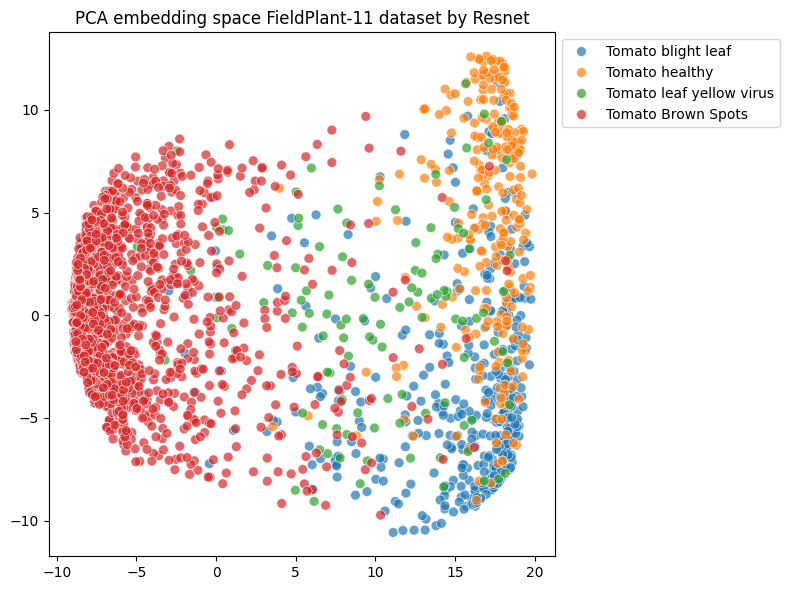

In [11]:
# PCA
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Giảm chiều bằng PCA hoặc t-SNE
# X = np.array(embeddings_np) # turn list => array (n_samples, n_features)
print(embeddings_np.shape)
pca = PCA(n_components=3) # n_components <= min(n_samples, n_features)
X_reduced = pca.fit_transform(embeddings_np) # n_features => 2 features,

# Vẽ
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=labels, palette="tab10", s=50, alpha=0.7)
plt.title(f"PCA embedding space {data_name} dataset by {model_name}")
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [ ]:
# Vẽ PCA 3D
from sklearn.preprocessing import LabelEncoder

# Encode string labels to integers
label_encoder = LabelEncoder()
label_ids = label_encoder.fit_transform(labels)  # array of ints

# Dùng label_ids để vẽ màu
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2],
    c=label_ids,
    cmap='tab10',
    s=50,
    alpha=0.7
)

# Gắn tên class tương ứng với màu
legend_labels = label_encoder.classes_
legend_handles = [plt.Line2D([0], [0], marker='o', color='w',
                             label=cls, markerfacecolor=plt.cm.tab10(i / len(legend_labels)),
                             markersize=8)
                  for i, cls in enumerate(legend_labels)]

ax.set_title(f"PCA 3D embedding of {data_name} dataset by {model_name}")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', title="Class")
plt.tight_layout()
plt.show()

### FCM cluster

/home/icnlab/anaconda3/envs/aiot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/icnlab/anaconda3/envs/aiot/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


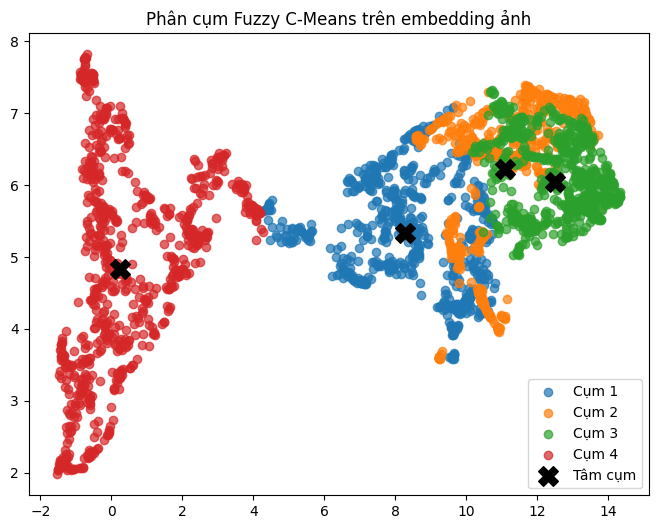

In [ ]:
# FCM cluster
import numpy as np
import skfuzzy as fuzz
from sklearn.preprocessing import LabelEncoder, StandardScaler
import umap.umap_ as umap
import matplotlib.pyplot as plt

def encode_labels(labels):
    """Mã hóa nhãn bằng LabelEncoder."""
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(labels)
    return y_encoded, len(np.unique(y_encoded))

def scale_and_reduce_dim(embeddings_np, n_components=4, random_state=42):
    """Chuẩn hóa dữ liệu và giảm chiều bằng UMAP."""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(embeddings_np)
    umap_model = umap.UMAP(n_components=n_components, random_state=random_state)
    X_reduced = umap_model.fit_transform(X_scaled)
    return X_reduced

def apply_fcm(X_reduced, n_clusters, m=2.0, error=0.005, maxiter=1000):
    """Áp dụng thuật toán Fuzzy C-Means lên dữ liệu."""
    data = X_reduced.T  # Transpose để đúng shape [features, samples]
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        data, c=n_clusters, m=m, error=error, maxiter=maxiter, init=None
    )
    cluster_labels = np.argmax(u, axis=0)
    return cntr, cluster_labels

def plot_clusters(X_reduced, cluster_labels, cntr, title='Phân cụm Fuzzy C-Means trên embedding ảnh'):
    """Vẽ biểu đồ các cụm và tâm cụm."""
    n_clusters = len(np.unique(cluster_labels))
    fig, ax = plt.subplots(figsize=(8, 6))
    for i in range(n_clusters):
        ax.scatter(
            X_reduced[cluster_labels == i, 0],
            X_reduced[cluster_labels == i, 1],
            label=f'Cụm {i+1}', alpha=0.7
        )
    ax.scatter(cntr[:, 0], cntr[:, 1], marker='X', s=200, c='black', label='Tâm cụm')
    ax.legend()
    ax.set_title(title)
    plt.show()

# === Ví dụ sử dụng ===
y_encoded, n_clusters = encode_labels(labels)
X_reduced = scale_and_reduce_dim(embeddings_np)
cntr, cluster_labels = apply_fcm(X_reduced, n_clusters)
plot_clusters(X_reduced, cluster_labels, cntr)


In [ ]:
# evaluate Fuzzy
from collections import Counter, defaultdict
import numpy as np
from sklearn.metrics import silhouette_samples
import pandas as pd

def compute_silhouette_scores(embeddings, cluster_labels):
    """Tính silhouette score cho từng điểm."""
    if len(np.unique(cluster_labels)) < 2:
        return np.zeros(len(embeddings))  # không thể tính silhouette với < 2 cụm
    return silhouette_samples(embeddings, cluster_labels)

def compute_label_distribution(labels_in_cluster):
    """Trả về dict: {label: count}, dùng cho phân phối nhãn."""
    label_counts = Counter(labels_in_cluster)
    total = sum(label_counts.values())
    distribution = {label: count / total for label, count in label_counts.items()}
    return dict(sorted(distribution.items(), key=lambda x: -x[1]))  # sort giảm dần

def evaluate_clusters_performance(true_labels, cluster_labels, embeddings, certainty_scores=None):
    true_labels = np.array(true_labels)
    cluster_labels = np.array(cluster_labels)
    embeddings = np.array(embeddings)

    unique_clusters = np.unique(cluster_labels)
    sil_samples = compute_silhouette_scores(embeddings, cluster_labels)
    results = {}

    for cluster in unique_clusters:
        idx = np.where(cluster_labels == cluster)[0]
        labels_in_cluster = true_labels[idx]
        sil_in_cluster = sil_samples[idx]
        label_counts = Counter(labels_in_cluster)

        dominant_label, dominant_count = label_counts.most_common(1)[0]
        purity = dominant_count / len(idx)

        result = {
            'size': len(idx),
            'purity': purity,
            'silhouette': float(np.mean(sil_in_cluster)) if len(idx) > 1 else None,
            'dominant_label': dominant_label,
            'label_distribution': compute_label_distribution(labels_in_cluster),
            'true_labels_in_cluster': labels_in_cluster,
            'embeddings_in_cluster': embeddings[idx]
        }

        if certainty_scores is not None:
            certs = certainty_scores[idx]
            result['mean_certainty'] = float(np.mean(certs))

        results[cluster] = result
    return results

def print_cluster_evaluation(results):
    """In ra kết quả đánh giá từng cụm."""
    for cid, info in results.items():
        print(f"Cluster {cid}:", end="  ")
        print(f"  Size: {info['size']}")
        print(f"  Purity: {info['purity']:.4f}", end="  ")
        print(f"  Silhouette: {info['silhouette']:.4f}" if info['silhouette'] is not None else "  Silhouette: N/A", end="  ")
        print(f"  Mean Certainty: {info.get('mean_certainty', 'N/A'):.4f}" if 'mean_certainty' in info else "  Mean Certainty: N/A")
        print(f"  Dominant Label: {info['dominant_label']}")
        print(f"  Label Distribution:")
        for label, frac in info['label_distribution'].items():
            print(f"    - {label}: {frac:.2%}")
        print()

cluster_labels = np.argmax(u, axis=0)
certainty_scores = np.max(u, axis=0)

cluster_eval = evaluate_clusters_performance(
    true_labels=labels,
    cluster_labels=cluster_labels,
    embeddings=X_reduced,
    certainty_scores=certainty_scores
)

print_cluster_evaluation(cluster_eval)

Cluster 0:    Size: 778
  Purity: 0.4807    Silhouette: 0.6513    Mean Certainty: 0.8687
  Dominant Label: Tomato blight leaf
  Label Distribution:
    - Tomato blight leaf: 48.07%
    - Tomato healthy: 35.35%
    - Tomato leaf yellow virus: 10.80%
    - Tomato Brown Spots: 5.78%

Cluster 1:    Size: 622
  Purity: 0.9952    Silhouette: 0.3783    Mean Certainty: 0.7272
  Dominant Label: Tomato Brown Spots
  Label Distribution:
    - Tomato Brown Spots: 99.52%
    - Tomato blight leaf: 0.32%
    - Tomato leaf yellow virus: 0.16%

Cluster 2:    Size: 671
  Purity: 0.9076    Silhouette: 0.3735    Mean Certainty: 0.6953
  Dominant Label: Tomato Brown Spots
  Label Distribution:
    - Tomato Brown Spots: 90.76%
    - Tomato leaf yellow virus: 4.47%
    - Tomato blight leaf: 4.17%
    - Tomato healthy: 0.60%

Cluster 3:    Size: 694
  Purity: 1.0000    Silhouette: 0.4175    Mean Certainty: 0.7325
  Dominant Label: Tomato Brown Spots
  Label Distribution:
    - Tomato Brown Spots: 100.00%



In [46]:
cluster_labels = cluster_eval[0]['true_labels_in_cluster']
cluster_embeddings = cluster_eval[0]['embeddings_in_cluster']

cluster_embeddings.shape, cluster_labels.shape

((778, 4), (778,))

In [47]:
%store cluster_labels cluster_embeddings

Stored 'cluster_labels' (ndarray)
Stored 'cluster_embeddings' (ndarray)


In [43]:
cluster_embedding[0]

array([-0.52911234,  7.441468  ,  6.097421  ,  6.9391046 ], dtype=float32)